In [1]:
import torch
import torch.nn.functional as F
from task.TaskGenerator import SinTaskGenerator
import matplotlib.pyplot as plt
from network.regressors_network import RegressorNetwork
from learner.MetaLearner import RegressorMAML

In [2]:
class ModelZPrevInput(torch.nn.Module):
    def __init__(self):
        super(ModelZPrevInput, self).__init__()
        self.enc1 = torch.nn.Linear(6, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=16, num_layers=3, batch_first=True)
        self.enc3 = torch.nn.Linear(16, 16)
        self.enc4 = torch.nn.Linear(16, 3)
        
    def encode(self, context, prev_z):
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        
        prev_z = prev_z.reshape(n_batch, 1, 3)
        prev_z = prev_z.repeat(1, seq_len, 1)
        
        context = torch.cat([context, prev_z], dim=2)
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        t = self.enc2(t)[0][:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)
        t = F.elu(self.enc3(t))
        return  self.enc4(t)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z):
        return self.encode(context, prev_z)


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.enc1 = torch.nn.Linear(3, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=16, num_layers=3, batch_first=True)
        self.enc3 = torch.nn.Linear(19, 16)
        self.enc4 = torch.nn.Linear(16, 3)
        
    def encode(self, context, prev_z):
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        t = self.enc2(t)[0][:, -1, :] # we are interested only in the last output of the sequence
        t = torch.cat([t, prev_z], dim=1)
        t = F.elu(t)
        t = F.elu(self.enc3(t))
        return  self.enc4(t)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z):
        return self.encode(context, prev_z)

In [3]:
model = ModelZPrevInput()
optimizer = torch.optim.Adam(model.parameters())

In [4]:
def loss_function(recon_f, f):
    MSE = F.mse_loss(recon_f, f)
    #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE 

In [5]:
task_gen = SinTaskGenerator(x_min=-5, x_max=5)
dataset = []

# Task parameters range
max_a = 0.1
min_a = 10

min_phase = -2
max_phase = 2

min_freq = 0.1
max_freq = 10

def sample_task(n_batches=10, test_perc=0, batch_size=128):
    a = (min_a - max_a) * torch.rand(1) + max_a
    phase = (min_phase - max_phase) * torch.rand(1) + max_phase
    f = (min_freq - max_freq) * torch.rand(1) + max_freq
    
    """
    a_t2 = a_t1 + torch.rand(1) * offset_a_max
    phase_t2 = phase_t1 + torch.rand(1) * offset_phase_max
    f_t2 = f_t1 + torch.rand(1) * offset_f_max
    """
    data = task_gen.get_data_loader(amplitude=a, 
                                    phase=phase,
                                    frequency=f,
                                    num_batches=n_batches,
                                    test_perc=test_perc, 
                                    batch_size=batch_size)

    return data, a, phase, f

# Dataset creation
n_tasks = 1000
data_set = []
a_set = []
phase_set = []
f_set = []
param = []
for _ in range(n_tasks):
    data, a, phase, f = sample_task(n_batches=1, test_perc=0, batch_size=128)
    data_set.append(data)
    a_set.append(a)
    phase_set.append(phase)
    f_set.append(f)
    param.append((a.item(), phase.item(), f.item()))

In [6]:
offset = 2

def batch_train_offset(epoch, n_batch=10):
    train_loss = 0
    n_batch = 32
    batch_per_task = 1
    task_idx = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    task_loader = [data_set[i] for i in task_idx]
    curr_param = [param[i] for i in task_idx]

    for k in range(batch_per_task):
        num_data_context = torch.randint(low=5, high=25, size=(1,)).item()
        idx = torch.randint(0, 128, (128,))
        ctx_idx = idx[0:num_data_context]
        
        context = torch.empty(n_batch, num_data_context, 3)
        target = torch.empty(n_batch, 3)

        # Retrieving data to be fed to the network 
        i = 0
        for t_idx, task in enumerate(task_loader):
            # Creating new task
            a_offset = torch.rand(1) * offset
            p_offset = torch.rand(1) * offset
            f_offset = torch.rand(1) * offset
            offset_param = torch.Tensor([a_offset, p_offset, f_offset])
            target[i] = offset_param

            # Creating context to be fed to the network 
            batch = task[k]['train']
            x = batch[0]
            task_pred = (curr_param[t_idx][0]+a_offset) * torch.sin((curr_param[t_idx][2]+f_offset)*x+(curr_param[t_idx][1]+p_offset))
            batch = torch.cat([batch[0], batch[1], task_pred], dim=1)
            context[i] = batch[ctx_idx]
            i+=1

        optimizer.zero_grad()
        curr_param = torch.Tensor(curr_param)
        z_hat = model(context, curr_param)

        # Compute reconstruction
        loss = loss_function(z_hat, target)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / (batch_per_task)




In [ ]:
n_epochs = 20000
#losses = []
#l_sum = 0
for i in range(n_epochs):
    l = batch_train_offset(i)
    l_sum += l
    losses.append(l)
    if i % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(i, l_sum/(i+1)))

====> Epoch: 0 Average loss: 4382.9726
====> Epoch: 100 Average loss: 43.5939
====> Epoch: 200 Average loss: 22.0019
====> Epoch: 300 Average loss: 14.7583
====> Epoch: 400 Average loss: 11.1271
====> Epoch: 500 Average loss: 8.9454
====> Epoch: 600 Average loss: 7.4894
====> Epoch: 700 Average loss: 6.4493
====> Epoch: 800 Average loss: 5.6689
====> Epoch: 900 Average loss: 5.0614
====> Epoch: 1000 Average loss: 4.5754
====> Epoch: 1100 Average loss: 4.1774
====> Epoch: 1200 Average loss: 3.8458
====> Epoch: 1300 Average loss: 3.5649
====> Epoch: 1400 Average loss: 3.3244
====> Epoch: 1500 Average loss: 3.1156
====> Epoch: 1600 Average loss: 2.9336
====> Epoch: 1700 Average loss: 2.7728
====> Epoch: 1800 Average loss: 2.6295
====> Epoch: 1900 Average loss: 2.5013
====> Epoch: 2000 Average loss: 2.3863
====> Epoch: 2100 Average loss: 2.2820
====> Epoch: 2200 Average loss: 2.1872
====> Epoch: 2300 Average loss: 2.1008
====> Epoch: 2400 Average loss: 2.0213
====> Epoch: 2500 Average loss

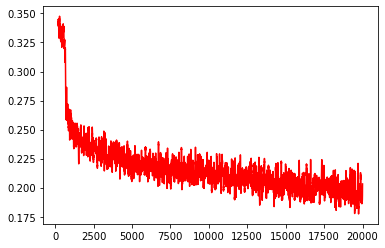

In [10]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,51, 3) 

plt.plot(x[200:], yhat[200:], color='red')
plt.show()

In [76]:
t1 = torch.randn(32, 22, 3)
t2 = torch.randn(32, 3)

torch.Size([32, 22, 6])